# Ejemplo de uso de Pyomo para resolver un problema de despacho económico

In [1]:
from pyomo.environ import Suffix, value
from pyomo.opt import SolverStatus, TerminationCondition, SolverFactory

**Conjuntos**
-  $N$ : Conjunto de nodos (indice $n$, $m$).
-  $J$ : Conjunto de unidades generadoras, (indice $j$).
-  $(n,m) \in E$ : Conjunto de ramas eléctricas o líneas de transmisión que se conectan entre los nodos $n$ y $m$.
-  $(j,n) \in E$ : Conjunto de unidades $j$ asociadas a nodo $n$.

**Parámetros**
-  $c_j$ : Costo de operación de la unidad generadora \( $j$ \).
-  $De_n$ : Demanda en el nodo \( $n$ \).
-  $P_j^\text{min}$ : Capacidad mínima de generación para la unidad generadora \( $j$ \).
-  $P_j^\text{max}$ : Capacidad máxima de generación para la unidad generadora \( $j$ \).
-  $B_{n,m}$ Susceptancia de la línea $(𝑛,𝑚)$
-  $Y_{n,m}^\text{max}$ Capacidad de transporte máxima de la línea $(𝑛,𝑚)$

**Variables de decisión**
-  $p_{j}$ : Generación de la unidad \( $j$ \) en el intervalo \( $t$ \).
-  $\delta_{n}$ : Ángulo de voltaje en el nodo \( $n$ \).

**model**
\begin{align*}
\text{Min} \quad & \sum_{j\in J} c_{j} p_{jt} \\
\text{Sujeto a:} \quad & \delta_{1} = 0 \\
& y_{n,m} = B_{n,m} (\delta_n - \delta_m), &  (n,m) \in E\\
& \sum_{i \in J: (j,n) \in JN}  p_{j} = De_{n} + \sum_{m \in N:(n,m) \in E} y_{n,m} & n\in N \\
& -Y_{nm}^\text{max} \leq y_{nm} \leq Y_{nm}^\text{max} & (n,m)\in E \\
& P_{j}^\text{min} \leq p_{j} \leq P_{j}^\text{max} & j\in J \\
& p_{j} \geq 0
\end{align*}

model extraido de: 
E. Castillo, A. J. Conejo, P. Pedregal, R. García y N. Alguacil (2002). Formulación y Resolución de Modelos de Programación Matemática en Ingeniería y Ciencia. Ciudad Real, España, 2002.

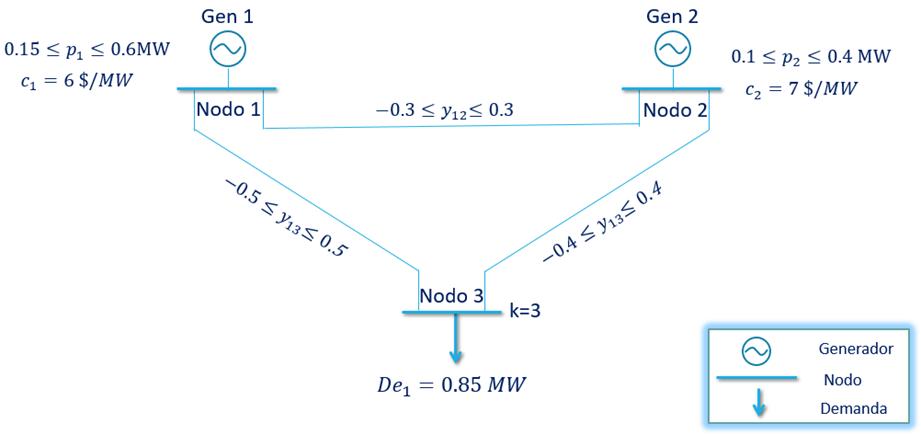

In [2]:
#Conjuntos
N    = {1,2,3}
J    = {1,2}
E    = { (1,2),(2,3),(3,1),(2,1),(3,2),(1,3) }
JN   = { (1,1),(2,2) }

# Parámetros
Pmin = {1: 0.15, 2: 0.10}  # Potencia mínima del generador
Pmax = {1: 0.60, 2: 0.40}  # Potencia máxima del generador
c = {1: 6.00, 2: 7.00}     # Costo de la unidad generadora
De = {1: 0.0, 2: 0.0, 3: 0.85}        # Demanda en el nodo

B = { # La susceptancia de la rama E en (1/ohms)
    (1, 2): 2.5, (1, 3): 3.5,
    (2, 1): 2.5, (2, 3): 3.0,
    (3, 1): 3.5, (3, 2): 3.0
}

Y = { # La capacidad de flujo máximo de la rama E en MW
    (1, 2): 0.3, (1, 3): 0.5,
    (2, 1): 0.3, (2, 3): 0.4,
    (3, 1): 0.5, (3, 2): 0.4
}

In [3]:
# importaciones de librerias
from pyomo.environ import *

# Aqui se define el model
def construir_modelo():

    # Crear un model
    model = ConcreteModel()
    
    # Definir conjuntos
    model.J = Set(initialize=J)  # Unidades generadoras
    model.N = Set(initialize=N)  # Nodos eléctricos
    model.E = Set(initialize=E, within=model.N * model.N)    # Ramas eléctricas
    model.JN = Set(initialize=JN, within=model.J * model.N)  # Unidades asociadas a nodos
    
    # Parámetros
    model.Pmin = Param(model.J, initialize=Pmin)  # Potencia mínima del generador
    model.Pmax = Param(model.J, initialize=Pmax)  # Potencia máxima del generador
    model.c = Param(model.J, initialize=c)    # Costo de la unidad generadora
    model.De = Param(model.N, initialize=De)  # Demanda en el nodo

    # Parámetros de susceptancia y capacidad de flujo máximo
    model.B = Param(model.E, initialize=B)  
    model.Y = Param(model.E, initialize=Y)  
    
    # Variables
    model.p = Var(model.J, within=NonNegativeReals)  # Generación de las unidades generadoras
    model.y = Var(model.E, within=Reals)  # Flujo en las ramas
    model.delta = Var(model.N, within=Reals)  # Ángulo de voltaje en los nodos
    
    # Función objetivo
    def obj_rule(model):
        return sum(model.c[j] * model.p[j] for j in model.J)
    model.obj = Objective(rule=obj_rule, sense=minimize)

    # Restricciones
    
    def flow(model, n, m):
        return model.y[n, m] == model.B[n, m] * (model.delta[n] - model.delta[m])
    model.flow = Constraint(model.E, rule=flow)

    def balance(model, n):
        return sum(model.p[j] for j, m in model.JN if m == n) == \
                model.De[n] + sum(model.y[n, m] for m in model.N if (n, m) in model.E)
    model.balance = Constraint(model.N, rule=balance)

    def flow_limit(model, n, m):
        return model.y[n, m] <= model.Y[n, m]
    model.flow_limit = Constraint(model.E, rule=flow_limit)
    
    def generation_limit_min(model, j):
        return model.Pmin[j] <= model.p[j]
    model.generation_limit_min = Constraint(model.J, rule=generation_limit_min)

    def generation_limit_max(model, j):
        return model.p[j] <= model.Pmax[j]
    model.generation_limit_max = Constraint(model.J, rule=generation_limit_max)

    def slack_node(model):
        return model.delta[3] == 0
    model.slack_node = Constraint(rule=slack_node)
    
    model.pprint()
    return model

In [4]:
model = construir_modelo()
# Create a 'rc' suffix component on the instance so the solver plugin will know which suffixes to collect
model.rc   = Suffix(direction=Suffix.IMPORT,datatype=Suffix.FLOAT)
model.dual = Suffix(direction=Suffix.IMPORT,datatype=Suffix.FLOAT)
SolverFactory('cplex', executable='C:/ILOG/CPLEX_Studio129/cplex/bin/x64_win64/cplex').solve(model).write()

model.pprint() 
print('\n z = ', model.obj())

(type: set).  This WILL potentially lead to nondeterministic behavior in Pyomo
(type: set).  This WILL potentially lead to nondeterministic behavior in Pyomo
6 Set Declarations
    E : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain   : Size : Members
        None :     2 : E_domain :    6 : {(2, 3), (1, 2), (2, 1), (3, 1), (3, 2), (1, 3)}
    E_domain : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    N*N :    9 : {(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)}
    J : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {1, 2}
    JN : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain    : Size : Members
        None :     2 : JN_domain :    2 : {(1, 1), (2, 2)}
    JN_domain : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    J*N :    6 : {

In [5]:
## Escribir el modelo en formato LP
model.write("problema.lp", io_options={'symbolic_solver_labels':True})

## Escribir el modelo en formato MPS
model.write("problema.mps" , io_options = {'symbolic_solver_labels':True})

('problema.mps', 2352120532432)

In [6]:
model.rc.pprint()

rc : Direction=Suffix.IMPORT, Datatype=Suffix.FLOAT
    Key      : Value
    delta[1] :   0.0
    delta[2] :   0.0
    delta[3] :   0.0
        p[1] :   0.0
        p[2] :   0.0
      y[1,2] :   0.0
      y[1,3] :   0.0
      y[2,1] :   0.0
      y[2,3] :   0.0
      y[3,1] :   0.0
      y[3,2] :   0.0


In [7]:
model.dual.pprint()

dual : Direction=Suffix.IMPORT, Datatype=Suffix.FLOAT
    Key                     : Value
                 balance[1] :                 6.0
                 balance[2] :                 7.0
                 balance[3] :  -7.833333333333333
                  flow[1,2] :                 6.0
                  flow[1,3] :   8.547619047619046
                  flow[2,1] :                 7.0
                  flow[2,3] :                 7.0
                  flow[3,1] :   7.833333333333333
                  flow[3,2] :   7.833333333333333
            flow_limit[1,2] :                 0.0
            flow_limit[1,3] : -2.5476190476190457
            flow_limit[2,1] :                 0.0
            flow_limit[2,3] :                 0.0
            flow_limit[3,1] :                 0.0
            flow_limit[3,2] :                 0.0
    generation_limit_max[1] :                 0.0
    generation_limit_max[2] :                 0.0
    generation_limit_min[1] :                -0.0
    genera

![alt text](image-1.png)